# Intro into tensorflow

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np

sys.path.insert(0, "..") 
from src.data import make_dataset

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf

In [5]:
datafile = Path("..") / "data/processed/data.npy"
logbase = Path("..") / "logs"
train, valid, test = make_dataset.load(datafile)
X_train, y_train = train

# Manual finetuning hyperparameters 
But creating a network is something that needs many iterations, normally. So, we would want to keep track of all the changes we make, and to compare them. Having to create matplotlib plots is not the best way to do that. We will use tensorboard to keep track. In addition, we want don't want to stop to soon, but we also want to avoid overfitting by training too long. Earlystopping is an easy way to do so.

In [6]:
%load_ext tensorboard
import datetime
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
from src.models import base, train_model

log_dir = logbase / "single_layer"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1,
                                                      profile_batch='500,520'
                                                      )

datashape=X_train.shape[1:]
model = base.basemodel(shape=datashape)
history = train_model.train(model, train, valid, 
                            epochs=100,
                            optimizer = 'sgd',
                            callbacks=[tensorboard_callback, early_stop],
                            verbose=1)

Epoch 1/100
387/387 [==============================] - 1s 1ms/step - loss: 0.7107 - mae: 0.6078 - mape: 35.8053 - val_loss: 0.4714 - val_mae: 0.4925 - val_mape: 29.9441
Epoch 2/100
387/387 [==============================] - 0s 1ms/step - loss: 0.4353 - mae: 0.4772 - mape: 27.7769 - val_loss: 0.5186 - val_mae: 0.4536 - val_mape: 26.7044
Epoch 3/100
387/387 [==============================] - 0s 812us/step - loss: 0.4026 - mae: 0.4581 - mape: 26.4450 - val_loss: 0.4280 - val_mae: 0.4410 - val_mape: 25.8756
Epoch 4/100
387/387 [==============================] - 0s 784us/step - loss: 0.3912 - mae: 0.4500 - mape: 25.9567 - val_loss: 0.3935 - val_mae: 0.4397 - val_mape: 26.3188
Epoch 5/100
387/387 [==============================] - 0s 777us/step - loss: 0.3815 - mae: 0.4440 - mape: 25.5639 - val_loss: 0.3875 - val_mae: 0.4333 - val_mape: 25.5353
Epoch 6/100
387/387 [==============================] - 0s 975us/step - loss: 0.3753 - mae: 0.4397 - mape: 25.3502 - val_loss: 0.3793 - val_mae: 0.430

The EarlyStopping keeps an eye at the validation set. It the validation set is not improving for more then 10 epochs, it aborts training and restores the last best epoch.

Usually, I would advise to use tensorboard. Note how I add the tensorboard_callback to `callbacks` while fitting the model.

There are multiple ways to open tensorboad.
## locally
1. If you run it locally, you can easily open it from inside the jupyter notebook with `%tensorboard --logdir ../logs/`
2. If you don't run it inside a browser, but in VS code, you can run `Python:
   Launch Tensorboard`
3. You can open tensorboard from the terminal. navigate to the directory where your logs are located, and run the command `tensorboard --logdir logs`. After that, you can open a browser at http://localhost:6006

## jupyterhub
On the jupyterhub, it is possible to open a tensorboad, but only with tensorflow 2.1.0. While we could downgrade tensorflow, this breaks the keras-tuner we will be using later on in this notebook. While tensorboard is really preferable to matplotlib, we will have to work around that on the jupyterhub. I created a `plot_result` function as a workaround.

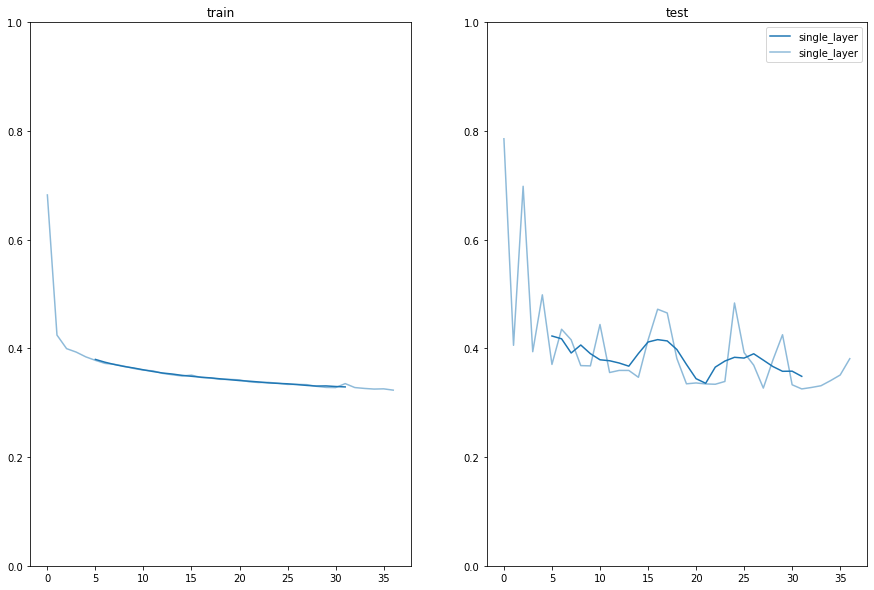

In [21]:
result = {}
result['single_layer'] = history

from src.visualization import visualize
visualize.plot_results(result, ymax = 1, yscale="linear", moving = 5)

So, this is our baseline model. Let's try to improve the result. Maybe more layers? Let's add three.

In [22]:
log_dir = logbase / "three_layers"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

model = base.basedeep_model(shape=datashape)
result['three_layers'] = train_model.train(model, train, valid, 
                            epochs=100,
                            callbacks=[tensorboard_callback, early_stop],
                            optimizer='sgd',
                            verbose=0)

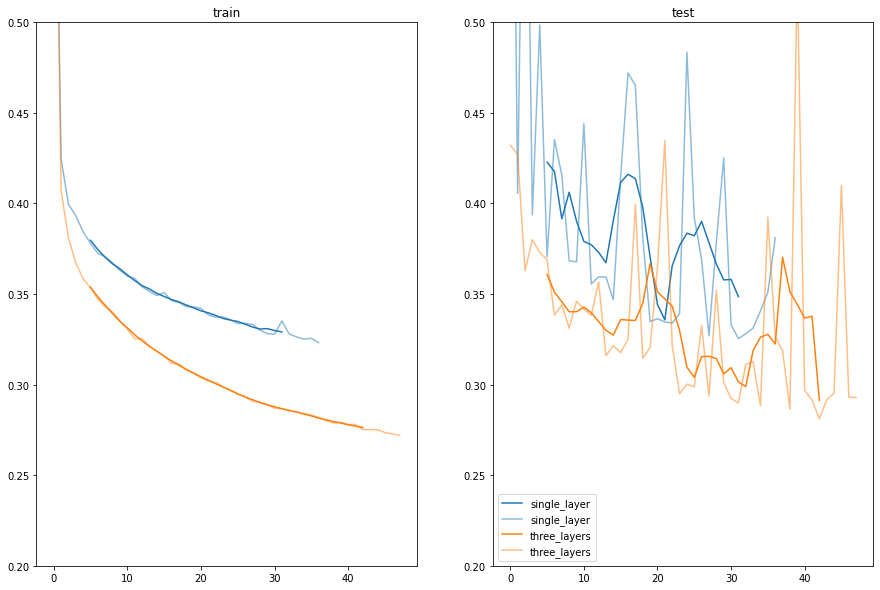

In [23]:
visualize.plot_results(result, ymin=0.2, ymax = 0.5, yscale="linear", moving = 5)

That seems to be working better. It trains faster, and more accurate. Now add momentum to the SGD

In [24]:
log_dir = logbase / "momentum"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model = base.basedeep_model(shape=datashape)
result['momentum'] = train_model.train(model, train, valid, 
                            epochs=100,
                            callbacks=[tensorboard_callback, early_stop],
                            optimizer=optimizer,
                            verbose=0)

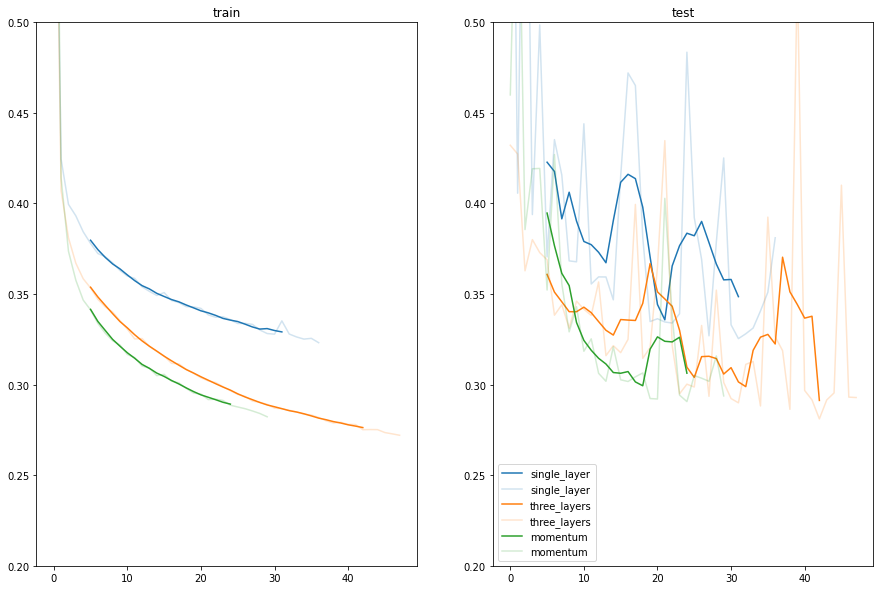

In [25]:
visualize.plot_results(result, ymin=0.2, ymax = 0.5, yscale="linear", moving = 5, alpha=0.2)

It's just a little bit better, but not much. Now compare that to Adam as an optimizer.

In [26]:
log_dir = logbase / "adam"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

model = base.basedeep_model(shape=datashape)
result['adam'] = train_model.train(model, train, valid, 
                            epochs=100,
                            callbacks=[tensorboard_callback, early_stop],
                            optimizer="Adam",
                            verbose=0)

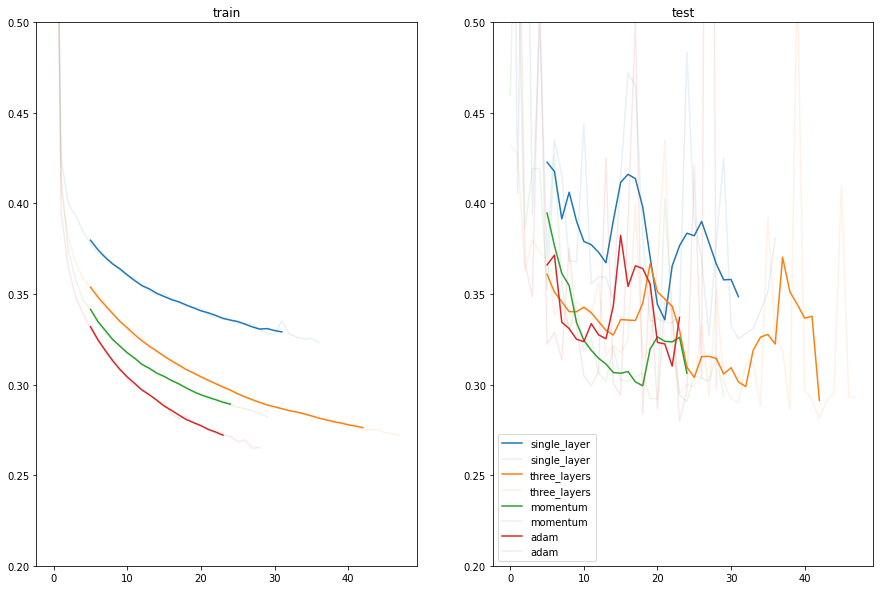

In [27]:
visualize.plot_results(result, ymin=0.2, ymax = 0.5, yscale="linear", moving = 5, alpha=0.1)